In [1]:
import os
import pydicom
import SimpleITK as sitk
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from multiprocessing import Pool

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
def load_dicom_image(file_path):
    dicom = sitk.ReadImage(file_path)
    img = sitk.GetArrayFromImage(dicom)[0]
    
    # Check if the image is a 2D array
    if img.ndim != 2:
        raise ValueError(f"Expected 2D image, got {img.ndim}D image")

    # Convert to uint8 if necessary
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Resize the image to 128x128
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [3]:
def extract_images_from_subfolder(subfolder, limit_per_subfolder):
    file_paths = []
    count = 0
    with os.scandir(subfolder) as it:
        for entry in it:
            if entry.is_file() and entry.name.endswith('.dcm'):
                file_paths.append(entry.path)
                count += 1
                if count >= limit_per_subfolder:
                    break
    return file_paths

def extract_images_into_dataframe(directory, limit_per_subfolder=15):
    all_files = []
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    
    # Process each subfolder sequentially
    for subfolder in subfolders:
        files = extract_images_from_subfolder(subfolder, limit_per_subfolder)
        all_files.extend(files)
    
    df = pd.DataFrame({'FilePath': all_files})
    return df

In [4]:
# Define paths and parameters
main_folder_path = 'data/train'
limit_per_subfolder = 15

# Extract 15 DICOM file paths per subfolder into a DataFrame
df = extract_images_into_dataframe(main_folder_path, limit_per_subfolder)

# Display the dataframe (optional)
print(df.shape)
print(df.head())

(360, 1)
                                     FilePath
0   data/train/1.2.826.0.1.3680043.128/16.dcm
1  data/train/1.2.826.0.1.3680043.128/103.dcm
2  data/train/1.2.826.0.1.3680043.128/117.dcm
3  data/train/1.2.826.0.1.3680043.128/498.dcm
4  data/train/1.2.826.0.1.3680043.128/329.dcm


In [5]:
df.head()

,FilePath
0,data/train/1.2.826.0.1.3680043.128/16.dcm
1,data/train/1.2.826.0.1.3680043.128/103.dcm
2,data/train/1.2.826.0.1.3680043.128/117.dcm
3,data/train/1.2.826.0.1.3680043.128/498.dcm
4,data/train/1.2.826.0.1.3680043.128/329.dcm


In [6]:
# Load images and create arrays
images = []
for file_path in df['FilePath']:
    try:
        img = load_dicom_image(file_path)
        images.append(img)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

images = np.array(images)
print(images.shape)

(360, 128, 128)


In [7]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [8]:
# Extract StudyInstanceUID from file paths (the penultimate part of the path)
df['StudyInstanceUID'] = df['FilePath'].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Optional: If you want to aggregate labels for each StudyInstanceUID in train_df
# This step assumes you may have multiple entries for the same StudyInstanceUID
train_df_grouped = train_df.groupby('StudyInstanceUID', as_index=False).agg({'patient_overall': 'first'})  # Use 'first' or another aggregation method

# Merge with train_df to get labels
df = df.merge(train_df_grouped[['StudyInstanceUID', 'patient_overall']], on='StudyInstanceUID', how='left')

# Extract labels
labels = df['patient_overall'].values
print(labels.shape)

# Assuming you have already loaded and preprocessed your images into a variable called 'images'
# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(360,)
(288, 128, 128) (288,)
(72, 128, 128) (72,)


In [9]:
print(df['StudyInstanceUID'].unique())
print(train_df_grouped['StudyInstanceUID'].unique())

['1.2.826.0.1.3680043.128' '1.2.826.0.1.3680043.143'
 '1.2.826.0.1.3680043.120' '1.2.826.0.1.3680043.324'
 '1.2.826.0.1.3680043.581' '1.2.826.0.1.3680043.575'
 '1.2.826.0.1.3680043.142' '1.2.826.0.1.3680043.384'
 '1.2.826.0.1.3680043.510' '1.2.826.0.1.3680043.234'
 '1.2.826.0.1.3680043.258' '1.2.826.0.1.3680043.53'
 '1.2.826.0.1.3680043.14' '1.2.826.0.1.3680043.482'
 '1.2.826.0.1.3680043.308' '1.2.826.0.1.3680043.166'
 '1.2.826.0.1.3680043.170' '1.2.826.0.1.3680043.342'
 '1.2.826.0.1.3680043.61' '1.2.826.0.1.3680043.271'
 '1.2.826.0.1.3680043.27' '1.2.826.0.1.3680043.358'
 '1.2.826.0.1.3680043.539' '1.2.826.0.1.3680043.501']
['1.2.826.0.1.3680043.10001' '1.2.826.0.1.3680043.10005'
 '1.2.826.0.1.3680043.10014' ... '1.2.826.0.1.3680043.9994'
 '1.2.826.0.1.3680043.9996' '1.2.826.0.1.3680043.9997']


In [10]:
df.head()

,FilePath,StudyInstanceUID,patient_overall
0,data/train/1.2.826.0.1.3680043.128/16.dcm,1.2.826.0.1.3680043.128,1
1,data/train/1.2.826.0.1.3680043.128/103.dcm,1.2.826.0.1.3680043.128,1
2,data/train/1.2.826.0.1.3680043.128/117.dcm,1.2.826.0.1.3680043.128,1
3,data/train/1.2.826.0.1.3680043.128/498.dcm,1.2.826.0.1.3680043.128,1
4,data/train/1.2.826.0.1.3680043.128/329.dcm,1.2.826.0.1.3680043.128,1


In [11]:
print(np.isnan(X_train).any())  # Should return False
print(np.isinf(X_train).any())  # Should return False
print(np.isnan(y_train).any())   # Should return False
print(np.isinf(y_train).any())   # Should return False

False
False
False
False


In [12]:
# Define and Train the Model
def create_model():
    inputs = Input(shape=(128, 128, 1))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

2024-10-28 13:50:12.367989: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-28 13:50:12.368012: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-28 13:50:12.368020: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-28 13:50:12.368050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-28 13:50:12.368067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-10-28 13:50:12.904328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4881 - loss: 0.8299 - val_accuracy: 0.5972 - val_loss: 0.6600
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5761 - loss: 0.6434 - val_accuracy: 0.5833 - val_loss: 0.5909
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6828 - loss: 0.5673 - val_accuracy: 0.6667 - val_loss: 0.5480
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6965 - loss: 0.5136 - val_accuracy: 0.7639 - val_loss: 0.4546
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7630 - loss: 0.4514 - val_accuracy: 0.7778 - val_loss: 0.4421
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7555 - loss: 0.4148 - val_accuracy: 0.7917 - val_loss: 0.3947
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8156 - loss: 0.3515 - val_accuracy: 0.7778 - val_loss: 0.3831
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8550 - loss: 0.3095 - val_accuracy: 0.8472 - val_loss: 0.4019
Epoch 9/10

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.83      0.91      0.87        44

    accuracy                           0.83        72
   macro avg       0.83      0.81      0.82        72
weighted avg       0.83      0.83      0.83        72

Accuracy: 0.8333333333333334


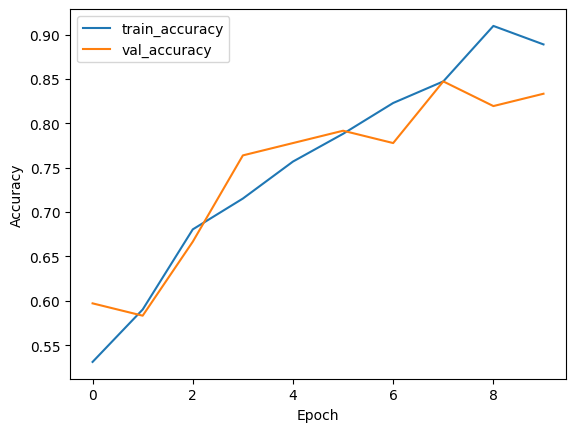

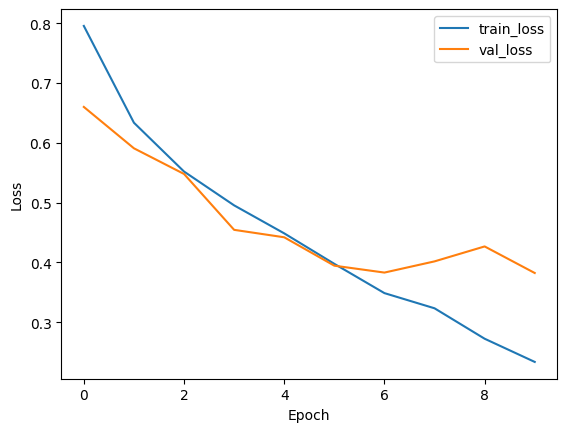

In [15]:
# Evaluate the Model
y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5).astype(int)
print(classification_report(y_val, y_val_pred))
print('Accuracy:', accuracy_score(y_val, y_val_pred))

# Visualize Training History
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()